<a href="https://colab.research.google.com/github/Alveuz/EquivalentImputation/blob/master/notebooks/ImputatorTester_alg_521.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

In [ ]:
import pickle
from google.colab import data_table

with open('data_vars.pkl','rb') as f:  # Python 3: open(..., 'rb')
    na_ixes = pickle.load(f)
    gfd_all_df = pickle.load(f)
    gdf_norm = pickle.load(f)
    names_dict = pickle.load(f)

f = open('pp_vars.pkl', 'rb')
scaler = pickle.load(f)
f.close()

data_table.DataTable(gfd_all_df, include_index=True, num_rows_per_page=10)

,Li,Na,K,Mg,Ca,Cl,SO4,HCO3,Temperature
0,0.0246,288.6,35.50,9.000001,54.80,48.00,272.00,558.800001,140.0
1,0.0896,410.0,39.40,5.600001,26.00,65.00,392.60,595.400001,162.0
2,0.1200,680.0,70.00,6.100001,42.00,115.00,34.00,NaN,155.0
3,0.3800,230.0,7.40,0.100001,35.00,NaN,NaN,NaN,95.0
4,0.4200,506.0,55.00,4.900001,11.60,80.00,471.00,NaN,163.0
...,...,...,...,...,...,...,...,...,...
703,NaN,1275.0,140.00,0.240001,1.20,136.00,729.00,NaN,202.0
704,NaN,160.0,11.05,0.002001,1.62,130.17,43.50,NaN,169.0
705,NaN,160.0,12.25,0.003001,1.86,135.67,42.34,NaN,168.0
706,NaN,189.0,9.20,0.007001,2.08,124.00,70.30,NaN,178.0


# Quality Metric for CV

- The sum of the differences between the eigenvalues of original $\lambda_{original}$ data vs eigenvalues of the imputed data $\lambda_{imputed}$.
  
  The eigenvalues are pairwise matched by posing the problem as the linear sum assigment problem

In [ ]:
import numpy as np
import numpy.linalg
import pandas as pd

from numpy import linalg as LA

from scipy.spatial.distance import pdist, squareform
from scipy.optimize import linear_sum_assignment

def cov_corr(df):
    cov = df.cov()
    corr = df.corr()
    cov_corr_df = pd.concat([cov, corr], axis=1)
    return cov_corr_df

def norm1_dist(df_corr_orig, df_corr_imputed):
  dist = np.linalg.norm(df_corr_orig-df_corr_imputed, ord = 1)
  return dist

def norm1_dist_per_ft(df_corr_orig, df_corr_imputed):
  nx, ny = df_corr_orig.shape
  tmp_names = df_corr_orig.columns
  zero_data = np.zeros(shape=(1,ny))
  dist = pd.DataFrame(zero_data, columns = tmp_names)
  
  for i in range(0, len(tmp_names)):
    dist.iloc[0,i] = np.linalg.norm(df_corr_orig.iloc[:,i]-df_corr_imputed.iloc[:,i], ord = 1)
  
  return dist

#The sum of the differences between the 
#eigenvalues of original data vs eigenvalues of the imputed data
#eigenvalues are pairwise matched by posing the problem as
#the linear sum assigment problem
def eigen_dist(df_corr_orig, df_corr_imputed):
  d,v = LA.eig(df_corr_orig)
  d2,v2 = LA.eig(df_corr_imputed)
  
  tmp_diff =  np.abs(d[:,np.newaxis] - d2)
  row_ind, col_ind = linear_sum_assignment(tmp_diff)
  
  # dist = tmp_diff[row_ind, col_ind].sum()
  # dist = np.max(np.abs(d[row_ind] - d2[col_ind]))
  dist = np.sum(np.abs(d[row_ind] - d2[col_ind]))
  # print(dist)
  return dist

# Model 5.2.1.

In [ ]:
from statsmodels.imputation.mice import MICE, MICEData
import statsmodels.regression.linear_model as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
tmp_data = gdf_norm.copy()
# tmp_data = tmp_data.drop(labels='CBE', axis = 1)

fml = "~".join(('Temperature',"+".join(names_dict['feat_names'] )))
print(fml)

imp = MICEData(tmp_data)
mice = MICE(fml, sm.OLS, imp)

# results = mice.fit(10, 10)
# print(results.summary())

imp.update_all(10)

# results = []
# for k in range(10):
#   print(k)
#   x = mice.next_sample()
#   results.append(x)

mice_imp_df = imp.data.copy()
# mice_imp_df['CBE'] = gdf_norm.CBE
with open('mice_imp_vars.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    # pickle.dump(imp, f)
    pickle.dump(mice_imp_df, f)

Temperature~Li+Na+K+Mg+Ca+Cl+SO4+HCO3


# Evaluation

### Original vs Imputed by MICE

In [ ]:
tmp_df = imp.data.copy()

corr_orig = gdf_norm[names_dict['feat_names']].corr()
corr_impu = tmp_df[names_dict['feat_names']].corr()

cc_orig = cov_corr(gdf_norm[names_dict['feat_names']])
cc_imp = cov_corr(tmp_df[names_dict['feat_names']])
# cc_imp = cov_corr(tmp_df[names_dict['feat_names']])
print('Frobenious:', norm1_dist(cc_orig,cc_imp))
print('EigenValues Difference:', eigen_dist(corr_orig,corr_impu))

norm1_dist_per_ft(cc_orig,cc_imp)

Frobenious: 0.8866215648679574
EigenValues Difference: 0.5570968583919651


,Li,Na,K,Mg,Ca,Cl,SO4,HCO3,Li,Na,K,Mg,Ca,Cl,SO4,HCO3
0,0.060564,0.02452,0.021877,0.02031,0.033256,0.046516,0.021709,0.005548,0.792977,0.220003,0.311514,0.466712,0.441335,0.295697,0.886622,0.538192


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


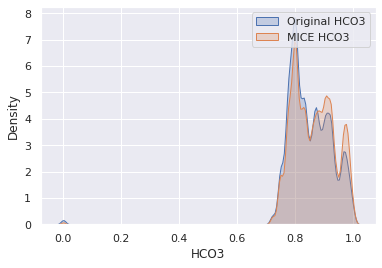

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

sns.set(color_codes=True)

# sns.distplot(gdf_norm.Li);
# sns.distplot(imp.data.Li);
sns.kdeplot(gdf_norm.HCO3, bw = 0.1, label="Original HCO3", shade=True)
sns.kdeplot(imp.data.HCO3, bw=0.1, label="MICE HCO3", shade=True)
plt.legend()
# imp.plot_bivariate('Mg', 'Li')